In [ ]:
!git clone https://github.com/ericoandre/fava_dataset.git

Cloning into 'fava_dataset'...
remote: Enumerating objects: 2991, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 2991 (delta 0), reused 3 (delta 0), pack-reused 2988
Receiving objects: 100% (2991/2991), 980.10 MiB | 42.31 MiB/s, done.
Checking out files: 100% (2978/2978), done.


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Nov 20 08:44:31 2021

@author: Erico Andre da Silva
"""

print(__doc__)


Created on Sat Nov 20 08:44:31 2021

@author: Erico Andre da Silva



## Impede Que Colabe perca a secao 

prescione F12 e digite esse codigo no console

```javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 10 16:50:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from __future__ import print_function

# Sys
import os

import numpy as np
import random as rn
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats # uniform, randint, expon, loguniform

# Deep Learning packages
import cv2 as cv
from imutils import paths

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score, precision_recall_curve, auc, roc_curve

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

%tensorflow_version 2.x
import tensorflow as tf

# Keras Core
from keras.utils import np_utils
from keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.layers import Input, BatchNormalization, GlobalMaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.models import Sequential, load_model, model_from_json

# Modelos
from tensorflow.keras.applications import Xception, ResNet50, VGG16, VGG19, InceptionV3, ResNet101, MobileNetV3Large

# Backend
from keras import backend as K

%matplotlib inline
mpl.style.use('ggplot')
plt.style.use('fivethirtyeight')
sns.set(context='notebook', palette='dark', color_codes=True)

print("Tensorflow version " + tf.__version__)
print("keras version " + tf.keras.__version__)
print("numpy version " + np.__version__)
print("pandas version " + pd.__version__)

Tensorflow version 2.8.0
keras version 2.8.0
numpy version 1.21.5
pandas version 1.3.5


# Funções

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def loadDataSet_(arg_dataset):
  print("Path", arg_dataset)
  print("[INFO] loading images...")
  imagePaths = list(paths.list_images(arg_dataset))
  X  = []
  label = []
  
  for imagePath in imagePaths:
    X.append(cv.imread(imagePath))
    label.append(imagePath.split(os.path.sep)[-2])

  X = np.array(X, dtype="float") / 255.0

  encoder = LabelEncoder()
  encoder.fit(label)
  y = encoder.transform(label)

  y = tf.keras.utils.to_categorical(y, 2)

  return (np.array(X), y, encoder, label)

In [ ]:
def extract_feature(modelo, endlayers, initlayers=0):
  modelosss = tf.keras.models.Model(inputs=modelo.layers[initlayers].input, outputs=modelo.layers[endlayers].output)

  X_train_rf = modelosss.predict(X_train)
  X_test_rf = modelosss.predict(X_test)

  y_train_rf = y_train.argmax(axis=1)
  y_test_rf = y_test.argmax(axis=1)

  return X_train_rf, y_train_rf, X_test_rf, y_test_rf

In [ ]:
def reset_random_seeds(SEED):
    os.environ['PYTHONHASHSEED']=str(SEED)
    tf.random.set_seed(SEED)
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    rn.seed(SEED)

In [ ]:
def search_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, model, param_grid, cv=5, callbacks=[], do_probabilities=False, search_mode='GridSearchCV', n_iterations=0):
  fitted_model = None
  if(search_mode == 'GridSearchCV'):
    gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv,verbose=1)
    fitted_model = gs.fit(X_train_data, y_train_data, callbacks=callbacks)
  elif (search_mode == 'RandomizedSearchCV'):
    rs = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=cv, n_iter=n_iterations,  verbose=1) # n_jobs=-1, scoring=scoring_fit,
    fitted_model = rs.fit(X_train_data, y_train_data, callbacks=callbacks)
  if(fitted_model != None):
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    return fitted_model, pred
  return fitted_model

In [ ]:
def plot_metrics(y_, predict, description, theme='Greens', H=None, epochs=None):
    acuracia = accuracy_score(y_, predict)
    precisao = precision_score(y_, predict)
    cobertura = recall_score(y_, predict)
    f1_armonica = f1_score(y_, predict)

    curva_precisao, curva_cobertura, thresholds = precision_recall_curve(y_, predict)
    auc_precisao_cobertura = auc(curva_cobertura, curva_precisao)
    fpr, tpr, thresholds_ = roc_curve(y_, predict) 
    matrix_confusion = confusion_matrix(y_, predict)

    tn, fp, fn, tp = matrix_confusion.ravel()

    Metrics[description] = [acuracia,auc_precisao_cobertura, precisao,cobertura, f1_armonica, (tn, fp, fn, tp)]

    # imprimindo
    print("-"*5,"-"*25, "-"*5)
    print("Acurácia de teste = {:.3f}".format(acuracia))
    print("AUC = {:.3f}".format(auc_precisao_cobertura))
    print("Precisão = {:.3f}, cobertura = {:.3f}".format(precisao, cobertura))
    print("F1 = {:.3f}".format(f1_armonica))
    print("-"*5,"-"*25, "-"*5)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
    fig.suptitle(description)

    sns.heatmap(matrix_confusion,annot=True, fmt='g', linewidth=0.3, cbar=True, cmap=theme, ax=axes[0], xticklabels=list(encode.classes_), yticklabels=list(encode.classes_)) # ,xticklabels=classes_label, yticklabels=classes_label
    #axes[0].annotate('VN', (0.3,0.5), fontweight='bold')
    #axes[0].annotate('FP', (1.3,0.5), fontweight='bold')
    #axes[0].annotate('FN', (0.3,1.5), fontweight='bold')
    #axes[0].annotate('VP', (1.3,1.5), fontweight='bold')
    axes[0].set_title('Matriz de confusão');
    axes[0].set_xlabel('rótulo Preditos')
    axes[0].set_ylabel('rótulo Verdadeiros')

    axes[1].set_title('Precisão-Cobertura: AUC={:.3f}'.format(auc_precisao_cobertura))
    axes[1].plot(curva_cobertura, curva_precisao, label='Precisão-Cobertura curve')
    axes[1].set_xlabel('Cobertura')
    axes[1].set_ylabel('Precisão')
    axes[1].legend(loc="lower left")

    # ROC-AUC Curve
    axes[2].set_title('ROC-AUC Plot')
    axes[2].set_xlabel('Verdadeiros Positivos Rate')
    axes[2].set_ylabel('Falsos Positivos Rate')
    axes[2].plot(fpr, tpr, label="ROC curve (area = {:.3f})".format(auc_precisao_cobertura))
    axes[2].plot([0, 1], ls="--")
    axes[2].plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    axes[2].legend(loc="lower left")
    
    plt.savefig('/content/drive/My Drive/modelos/{0}/{0}.png'.format(description), dpi=500)
    plt.savefig('/content/drive/My Drive/modelos/{0}/{0}.eps'.format(description), dpi=500)
    plt.show()

    ScoreModelo = pd.DataFrame.from_dict(
      Metrics,
      orient="index",
      columns=["Accuracia", "ACC", "Precision","Recall", "F1", "Matrix Conf"],
    )
    ScoreModelo.to_csv("/content/drive/My Drive/modelos/{0}/score_modelo_{0}.csv".format(description), sep=';')

    print(ScoreModelo)

    if H:
      plt.rcParams["figure.figsize"] = (18,6)
      # plot the training loss and accuracy
      plt.style.use("ggplot")
      plt.figure()
      plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
      plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
      plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
      plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
      plt.title("Training Loss and Accuracy on Dataset {}")
      plt.xlabel("Epoch #")
      plt.ylabel("Loss/Accuracy")
      plt.legend(loc="lower left")
      plt.show()

In [ ]:
def resumo_modelo(model, y_test, pred, thema, description):
  print("[INFO] {} evaluating network...".format(description))
  print("Best: {:.4f} \nusing {}".format(model.best_score_, model.best_params_))
  print(classification_report(y_test, pred, target_names=list(encode.classes_)))
  save_object(model, description)
  plot_metrics(y_test, pred, description, thema)

In [ ]:
from pickle import dump, load, HIGHEST_PROTOCOL

def save_object(obj, filename):
  path="/content/drive/My Drive/modelos/{0}/".format(filename)
  if not os.path.exists(path):
    os.makedirs(path)

  try:
    obj.best_estimator_.model.save_weights(filepath=path+"weights/ModelWeights")
    obj.best_estimator_.model.save(path+'modelo/Model.h5', save_format='h5')
  except Exception as e:
    pass

  pd.DataFrame(obj.cv_results_).to_csv(path+"scores_{0}.csv".format(filename), sep=';')
  with open(path+"model_{0}.pkl".format(filename), 'wb') as outp:
    dump(obj, outp, HIGHEST_PROTOCOL)

## Modelos

In [ ]:
def modelo_inception_v3(width, height, depth, l2_penalty, dropout_rate, neurons, atvation, optimizer, n_class, fine_tune=0, activation='softmax', mlp=True):
  
  inception = InceptionV3(input_shape=(height, width, depth), include_top=False, weights='imagenet')
  
  if fine_tune > 0:
    for layer in inception.layers[:-fine_tune]:
      layer.trainable = False 
  else:
    for layer in inception.layers:
      layer.trainable = False

  x = Flatten(name="flatten")(inception.output)
  x = Dense(neurons, kernel_regularizer=l2_penalty, activation=atvation, name="dense1")(x)
  x = Dropout(dropout_rate, name="dropout1")(x)
  out = Dense(n_class, kernel_regularizer=l2_penalty, activation=activation, name="dense_output")(x)

  modelo = tf.keras.models.Model(inputs=inception.input, outputs=out)

  loss = 'categorical_crossentropy' if n_class > 2 else 'binary_crossentropy'

  modelo.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

  return modelo

In [ ]:
def modelo_vgg16(width, height, depth, l2_penalty, dropout_rate, neurons, atvation, optimizer, n_class, fine_tune=0, activation='softmax', mlp=True):

  vgg = VGG16(input_shape=(height, width, depth), include_top=False, weights='imagenet')

  if fine_tune > 0:
    for layer in vgg.layers[:-fine_tune]:
      layer.trainable = False 
  else:
    for layer in vgg.layers:
      layer.trainable = False

  x = Flatten(name="flatten")(vgg.output)
  x = Dense(neurons, kernel_regularizer=l2_penalty, activation=atvation, name="dense1")(x)
  x = Dropout(dropout_rate, name="dropout1")(x)
  out = Dense(n_class, kernel_regularizer=l2_penalty, activation=activation, name="dense_output")(x)

  modelo = tf.keras.models.Model(inputs=vgg.input, outputs=out)
  
  loss = 'categorical_crossentropy' if n_class > 2 else 'binary_crossentropy'
  
  modelo.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
  return modelo

In [ ]:
def modelo_vgg19(width, height, depth, l2_penalty, dropout_rate, neurons, atvation, optimizer, n_class, fine_tune=0, activation='softmax', mlp=True):
  
  vgg19 = VGG19(input_shape=(height, width, depth), include_top=False, weights='imagenet')

  if fine_tune > 0:
    for layer in vgg19.layers[:-fine_tune]:
      layer.trainable = False 
  else:
    for layer in vgg19.layers:
      layer.trainable = False

  x = Flatten(name="flatten")(vgg19.output)
  x = Dense(neurons, kernel_regularizer=l2_penalty, activation=atvation, name="dense1")(x)
  x = Dropout(dropout_rate, name="dropout1")(x)
  out = Dense(n_class, kernel_regularizer=l2_penalty, activation=activation, name="dense_output")(x)

  modelo = tf.keras.models.Model(inputs=vgg19.input, outputs=out)
  
  loss = 'categorical_crossentropy' if n_class > 2 else 'binary_crossentropy'
  
  modelo.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
  return modelo

In [ ]:
def modelo_xception(width, height, depth, l2_penalty, dropout_rate, neurons, atvation, optimizer, n_class, fine_tune=0, activation='softmax', mlp=True):

  xception = Xception(input_shape=(height, width, depth), include_top=False, weights='imagenet')

  if fine_tune > 0:
    for layer in xception.layers[:-fine_tune]:
      layer.trainable = False 
  else:
    for layer in xception.layers:
      layer.trainable = False

  x = Flatten(name="flatten")(xception.output)
  x = Dense(neurons, kernel_regularizer=l2_penalty, activation=atvation, name="dense1")(x)
  x = Dropout(dropout_rate, name="dropout1")(x)
  out = Dense(n_class, kernel_regularizer=l2_penalty, activation=activation, name="dense_output")(x)

  modelo = tf.keras.models.Model(inputs=xception.input, outputs=out)
  
  loss = 'categorical_crossentropy' if n_class > 2 else 'binary_crossentropy'
  
  modelo.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
  return modelo

In [ ]:
def modelo_cnn(width, height, depth, l2_penalty, dropout_rate, neurons, atvation, optimizer, n_class, activation='softmax', mlp=True):
  model = Sequential()
  
  inputShape = (height, width, depth)
  if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
 
  model.add(Conv2D(64, (3, 3), input_shape=inputShape, padding="same", kernel_regularizer=l2_penalty, activation=atvation, name='block1_conv1'))
  model.add(Conv2D(32, (2, 2), padding="same", kernel_regularizer=l2_penalty, activation=atvation, name='block1_conv2'))
  model.add(MaxPooling2D(pool_size=(2, 2), name='block1_pool'))
  model.add(Dropout(dropout_rate, name='block1_dropout'))

  model.add(Flatten(name='out_flatten'))
  model.add(Dense(neurons, kernel_regularizer=l2_penalty, activation=atvation, name="dense1"))
  model.add(Dropout(dropout_rate, name="dropout1"))
  model.add(Dense(n_class, activation=activation, name="dense_output"))

  loss = 'categorical_crossentropy' if n_class > 2 else 'binary_crossentropy'
 
  model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
  return model

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import Xception, ResNet50, VGG16, VGG19, InceptionV3, ResNet101, MobileNetV3Large

# model = MobileNetV3Large(weights="imagenet")
# model = ResNet101(weights="imagenet")
# model = Xception(weights="imagenet",classifier_activation="softmax")
# model = ResNet50(weights='imagenet')
# model = VGG16(weights='imagenet')
# model = VGG19(weights='imagenet')
# model =  InceptionV3(weights='imagenet')

# plot_model(model, to_file='model.png')

# Atributos

In [ ]:
seed = 42
teste_size=0.3

largura=200
altura=267
custon_depth=3

np.random.seed(seed)
Metrics = dict()

reset_random_seeds(seed)

(X, y, encode, label) = loadDataSet_("fava_dataset/imagens_aumentada{}x{}".format(200,267))

from sklearn.model_selection import train_test_split
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=teste_size, random_state=seed)

Path fava_dataset/imagens_aumentada200x267
[INFO] loading images...


In [ ]:
n_iter_search=50

param_grid = dict()

param_grid['dropout_rate'] = [0.5, 0.6, 0.7, 0.8, 0.9, 0.10, 0.11, 0.12]
param_grid['epochs'] = stats.randint(50, 500)
param_grid['batch_size'] = [16, 32, 64, 128]
param_grid['optimizer'] = ['adam', 'sgd', 'rmsprop', 'nadam']
param_grid['atvation']=['relu', 'sigmoid']
param_grid['neurons']= [32, 64, 128, 256]

kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=2, verbose=1, mode="min", baseline=None, restore_best_weights=False)
modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="weights-{epoch:02d}-{accuracy:.2f}.hdf5", monitor='accuracy', verbose=1, save_best_only=True,save_weights_only=True, mode='max')
reducelronplateau_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="accuracy", factor=0.5, patience=5, verbose=0,min_delta=1e-4,cooldown=0,min_lr=0.00001)

## Imagens


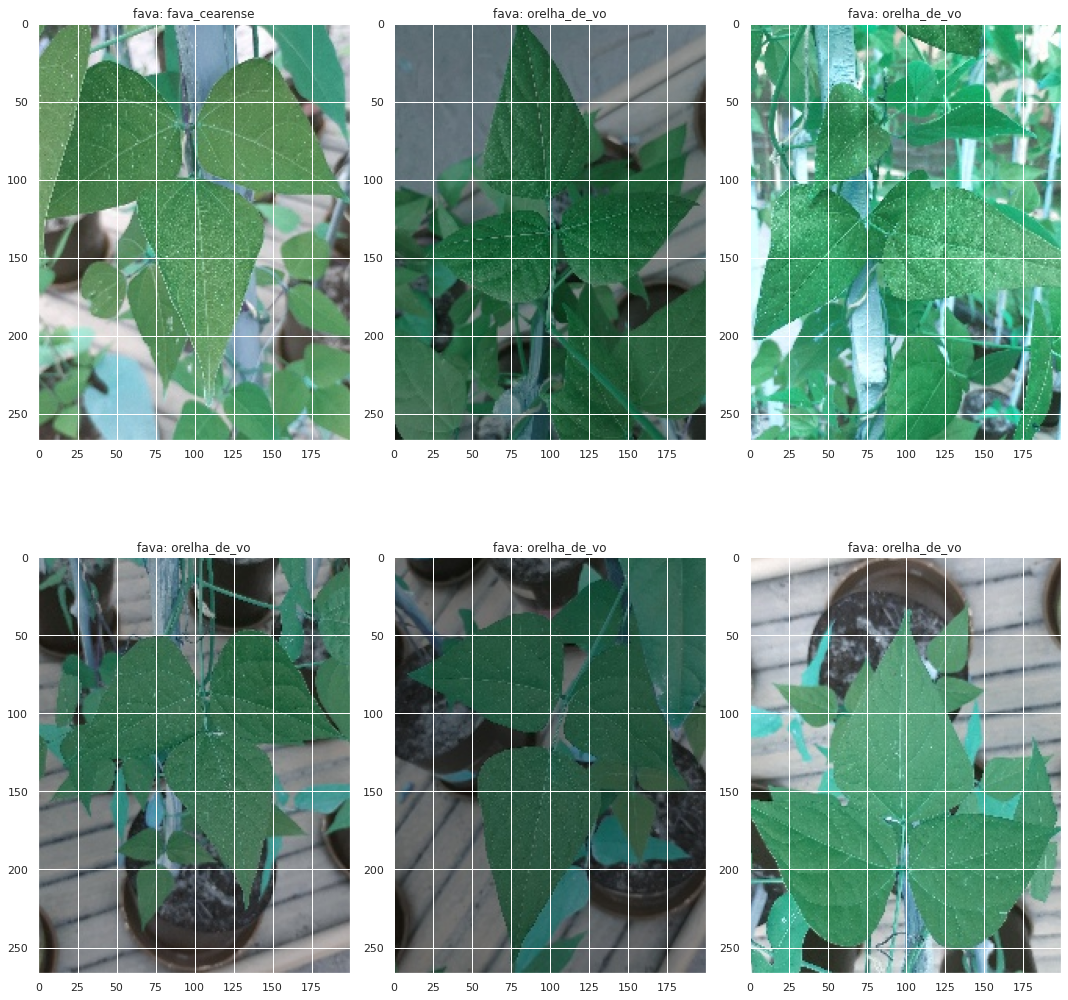

In [ ]:
fig,ax=plt.subplots(2,3)
fig.set_size_inches(15,15)
for i in range(2):
  for j in range (3):
    r = rn.randint(0,len(label))
    ax[i,j].imshow(X[r][:,:,::-1])
    ax[i,j].set_title('fava: ' + label[r])
plt.tight_layout()

# CNN COM MLP

## CNN

In [ ]:
%%time

model_clf = KerasClassifier(build_fn=modelo_cnn, width=largura, height=altura, depth=custon_depth, n_class=len(encode.classes_), l2_penalty=l2(2e-4), verbose=1)
model_cnn, pred_cnn = search_pipeline(X_train, X_test, y_train, y_test, model_clf, param_grid, cv=kfold, n_iterations=n_iter_search, callbacks=[earlystopping_callback], do_probabilities=False, search_mode='RandomizedSearchCV')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 16/154
48/48 [==============================] - 4s 84ms/step - loss: 0.1595 - accuracy: 0.9844
Epoch 17/154
48/48 [==============================] - 4s 85ms/step - loss: 0.2222 - accuracy: 0.9635
Epoch 18/154
48/48 [==============================] - 4s 84ms/step - loss: 0.4183 - accuracy: 0.9544
Epoch 18: early stopping
13/13 [==============================] - 0s 21ms/step - loss: 0.5884 - accuracy: 0.7617
Epoch 1/154
49/49 [==============================] - 5s 84ms/step - loss: 1.6563 - accuracy: 0.5475
Epoch 2/154
49/49 [==============================] - 4s 84ms/step - loss: 0.7407 - accuracy: 0.6307
Epoch 3/154
49/49 [==============================] - 4s 84ms/step - loss: 0.7611 - accuracy: 0.6489
Epoch 4/154
49/49 [==============================] - 4s 84ms/step - loss: 0.5807 - accuracy: 0.7971
Epoch 5/154
49/49 [==============================] - 4s 84ms/step - loss: 0.5062 - accuracy: 0.8531
Epoch 6/154
49/49 [======

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/usr/loca

Epoch 1/364
61/61 [==============================] - 5s 75ms/step - loss: 1.0335 - accuracy: 0.6587
Epoch 2/364
61/61 [==============================] - 5s 75ms/step - loss: 0.4317 - accuracy: 0.8907
Epoch 3/364
61/61 [==============================] - 5s 75ms/step - loss: 0.3088 - accuracy: 0.9480
Epoch 4/364
61/61 [==============================] - 5s 75ms/step - loss: 0.1766 - accuracy: 0.9875
Epoch 5/364
61/61 [==============================] - 5s 75ms/step - loss: 0.1229 - accuracy: 0.9990
Epoch 6/364
61/61 [==============================] - 5s 75ms/step - loss: 0.0898 - accuracy: 1.0000
Epoch 7/364
61/61 [==============================] - 5s 75ms/step - loss: 0.0742 - accuracy: 0.9990
Epoch 8/364
61/61 [==============================] - 5s 74ms/step - loss: 0.2038 - accuracy: 0.9636
Epoch 9/364
61/61 [==============================] - 5s 74ms/step - loss: 0.1207 - accuracy: 0.9958
Epoch 9: early stopping
CPU times: user 2h 32min 25s, sys: 2min 27s, total: 2h 34min 53s
Wall time: 

[INFO] CNN MLP evaluating network...
Best: 0.9074 
using {'atvation': 'relu', 'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 364, 'neurons': 128, 'optimizer': 'adam'}
               precision    recall  f1-score   support

fava_cearense       0.96      0.94      0.95       194
 orelha_de_vo       0.95      0.97      0.96       219

     accuracy                           0.95       413
    macro avg       0.95      0.95      0.95       413
 weighted avg       0.95      0.95      0.95       413

----- ------------------------- -----
Acurácia de teste = 0.954
AUC = 0.966
Precisão = 0.946, cobertura = 0.968
F1 = 0.957
----- ------------------------- -----


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


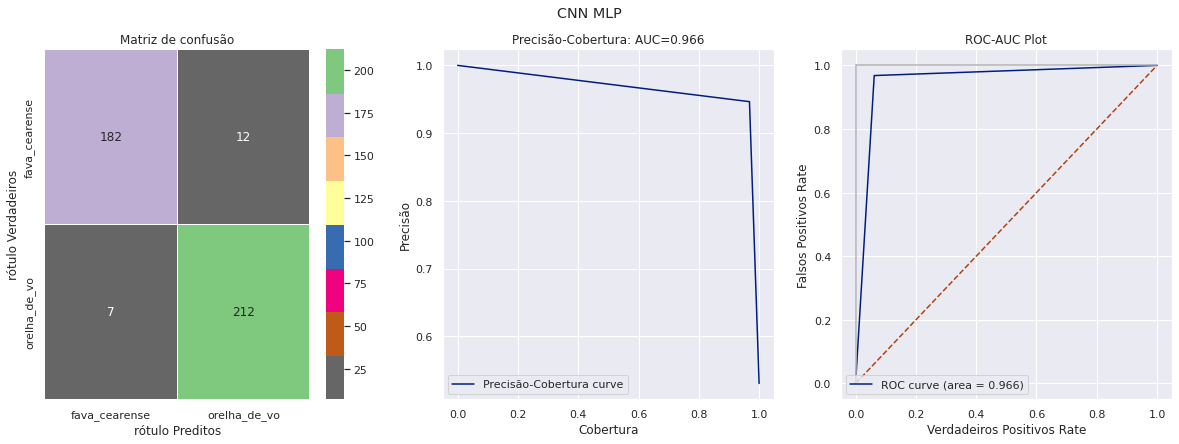

In [ ]:
resumo_modelo(model_cnn, y_test.argmax(axis=1), pred_cnn, "Accent_r", "CNN MLP")

## Inception v3

In [ ]:
%%time

kerasclassifier_inception = KerasClassifier(build_fn=modelo_inception_v3, width=largura, height=altura, depth=custon_depth, n_class=len(set(label)),l2_penalty=l2(2e-4), verbose=1)
model_inception , pred_inception  = search_pipeline(X_train, X_test, y_train, y_test, kerasclassifier_inception, param_grid, cv=kfold, n_iterations=n_iter_search, callbacks=[earlystopping_callback], do_probabilities=False, search_mode='RandomizedSearchCV')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


A saída de streaming foi truncada nas últimas 5000 linhas.
13/13 [==============================] - 1s 83ms/step - loss: 1.0167 - accuracy: 0.7386
Epoch 11/267
13/13 [==============================] - 1s 84ms/step - loss: 0.2765 - accuracy: 0.9441
Epoch 12/267
13/13 [==============================] - 1s 83ms/step - loss: 0.3904 - accuracy: 0.8960
Epoch 13/267
13/13 [==============================] - 1s 83ms/step - loss: 0.2282 - accuracy: 0.9675
Epoch 14/267
13/13 [==============================] - 1s 82ms/step - loss: 0.2133 - accuracy: 0.9740
Epoch 15/267
13/13 [==============================] - 1s 81ms/step - loss: 0.1891 - accuracy: 0.9766
Epoch 16/267
13/13 [==============================] - 1s 84ms/step - loss: 0.1937 - accuracy: 0.9753
Epoch 17/267
13/13 [==============================] - 1s 83ms/step - loss: 0.1768 - accuracy: 0.9857
Epoch 18/267
13/13 [==============================] - 1s 83ms/step - loss: 0.2003 - accuracy: 0.9740
Epoch 19/267
13/13 [=========================

[INFO] Inception MLP evaluating network...
Best: 0.9698 
using {'atvation': 'sigmoid', 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 155, 'neurons': 256, 'optimizer': 'sgd'}
               precision    recall  f1-score   support

fava_cearense       0.97      0.99      0.98       201
 orelha_de_vo       0.99      0.97      0.98       212

     accuracy                           0.98       413
    macro avg       0.98      0.98      0.98       413
 weighted avg       0.98      0.98      0.98       413

----- ------------------------- -----
Acurácia de teste = 0.978
AUC = 0.986
Precisão = 0.986, cobertura = 0.972
F1 = 0.979
----- ------------------------- -----


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


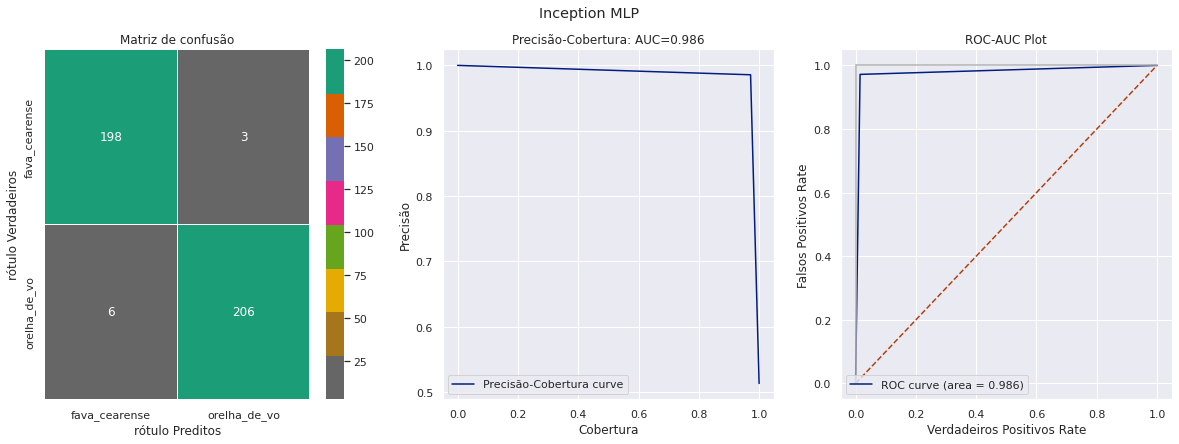

In [ ]:
resumo_modelo(model_inception, y_test.argmax(axis=1), pred_inception, "Dark2_r", "Inception MLP")

## VGG16

In [ ]:
%%time

kerasclassifier_vgg16 = KerasClassifier(build_fn=modelo_vgg16, width=largura, height=altura, depth=custon_depth, n_class=len(set(label)),l2_penalty=l2(2e-4), verbose=1)
model_vgg16 , pred_vgg16  = search_pipeline(X_train, X_test, y_train, y_test, kerasclassifier_vgg16, param_grid, cv=kfold, n_iterations=n_iter_search, callbacks=[earlystopping_callback], do_probabilities=False, search_mode='RandomizedSearchCV')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


A saída de streaming foi truncada nas últimas 5000 linhas.
25/25 [==============================] - 2s 85ms/step - loss: 0.0298 - accuracy: 1.0000
Epoch 15/166
25/25 [==============================] - 2s 85ms/step - loss: 0.0229 - accuracy: 1.0000
Epoch 16/166
25/25 [==============================] - 2s 85ms/step - loss: 0.0258 - accuracy: 0.9987
Epoch 17/166
25/25 [==============================] - 2s 85ms/step - loss: 0.0238 - accuracy: 1.0000
Epoch 17: early stopping
6/6 [==============================] - 1s 86ms/step - loss: 0.0755 - accuracy: 0.9792
Epoch 1/254
12/12 [==============================] - 4s 161ms/step - loss: 0.6673 - accuracy: 0.6419
Epoch 2/254
12/12 [==============================] - 2s 164ms/step - loss: 0.4998 - accuracy: 0.7630
Epoch 3/254
12/12 [==============================] - 2s 162ms/step - loss: 0.3268 - accuracy: 0.9115
Epoch 4/254
12/12 [==============================] - 2s 163ms/step - loss: 0.2842 - accuracy: 0.9323
Epoch 5/254
12/12 [================

[INFO] VGG16 MLP evaluating network...
Best: 0.9729 
using {'atvation': 'relu', 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 166, 'neurons': 64, 'optimizer': 'nadam'}
               precision    recall  f1-score   support

fava_cearense       0.96      0.96      0.96       194
 orelha_de_vo       0.96      0.97      0.97       219

     accuracy                           0.96       413
    macro avg       0.96      0.96      0.96       413
 weighted avg       0.96      0.96      0.96       413

INFO:tensorflow:Assets written to: ram://5df939a4-f9a2-42ca-9027-8cc0d1bcec27/assets
----- ------------------------- -----
Acurácia de teste = 0.964
AUC = 0.974
Precisão = 0.964, cobertura = 0.968
F1 = 0.966
----- ------------------------- -----


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


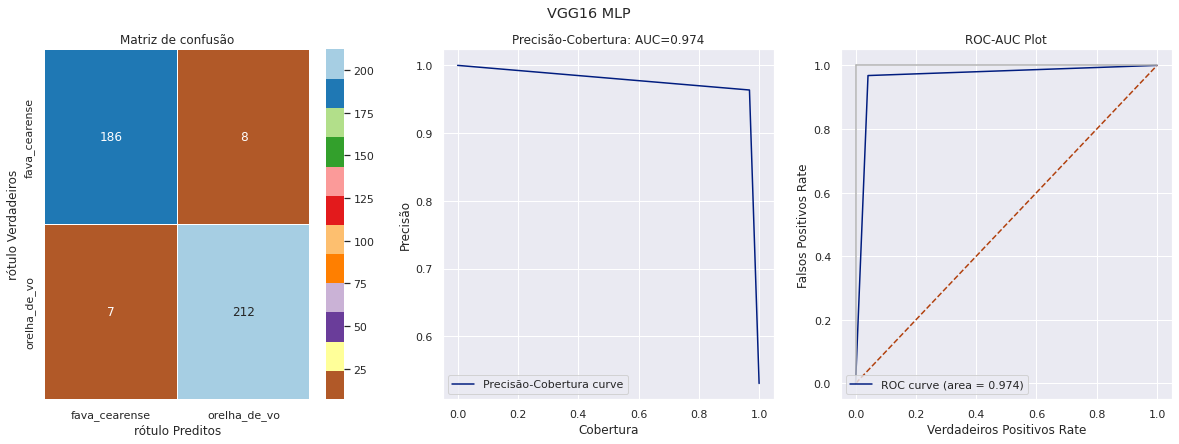

            Accuracia       ACC  Precision    Recall        F1  \
CNN TREE     0.973366  0.978926   0.964286  0.986301  0.975169   
VGG16 TREE   0.995157  0.997855   1.000000  0.990868  0.995413   
VGG19 TREE   0.992736  0.996783   1.000000  0.986301  0.993103   
VGG16 MLP    0.963680  0.974311   0.963636  0.968037  0.965831   

                 Matrix Conf  
CNN TREE    (186, 8, 3, 216)  
VGG16 TREE  (194, 0, 2, 217)  
VGG19 TREE  (194, 0, 3, 216)  
VGG16 MLP   (186, 8, 7, 212)  


In [ ]:
resumo_modelo(model_vgg16, y_test.argmax(axis=1), pred_vgg16, "Paired_r", "VGG16 MLP")

## VGG19

In [ ]:
%%time

kerasclassifier_vgg19 = KerasClassifier(build_fn=modelo_vgg19, width=largura, height=altura, depth=custon_depth, n_class=len(set(label)),l2_penalty=l2(2e-4), verbose=1)
model_vgg19 , pred_vgg19  = search_pipeline(X_train, X_test, y_train, y_test, kerasclassifier_vgg19, param_grid, cv=kfold, n_iterations=n_iter_search, callbacks=[earlystopping_callback], do_probabilities=False, search_mode='RandomizedSearchCV')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


A saída de streaming foi truncada nas últimas 5000 linhas.
25/25 [==============================] - 2s 97ms/step - loss: 0.2837 - accuracy: 0.9194
Epoch 9/243
25/25 [==============================] - 2s 97ms/step - loss: 0.2865 - accuracy: 0.9129
Epoch 10/243
25/25 [==============================] - 2s 96ms/step - loss: 0.2281 - accuracy: 0.9376
Epoch 11/243
25/25 [==============================] - 2s 96ms/step - loss: 0.2065 - accuracy: 0.9519
Epoch 12/243
25/25 [==============================] - 2s 97ms/step - loss: 0.1946 - accuracy: 0.9571
Epoch 13/243
25/25 [==============================] - 2s 96ms/step - loss: 0.1755 - accuracy: 0.9584
Epoch 14/243
25/25 [==============================] - 2s 96ms/step - loss: 0.2098 - accuracy: 0.9441
Epoch 15/243
25/25 [==============================] - 2s 96ms/step - loss: 0.1488 - accuracy: 0.9688
Epoch 16/243
25/25 [==============================] - 2s 97ms/step - loss: 0.1495 - accuracy: 0.9714
Epoch 17/243
25/25 [==========================

[INFO] VGG19 MLP evaluating network...
Best: 0.9615 
using {'atvation': 'sigmoid', 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 87, 'neurons': 64, 'optimizer': 'adam'}
               precision    recall  f1-score   support

fava_cearense       0.95      0.98      0.97       201
 orelha_de_vo       0.98      0.95      0.97       212

     accuracy                           0.97       413
    macro avg       0.97      0.97      0.97       413
 weighted avg       0.97      0.97      0.97       413

----- ------------------------- -----
Acurácia de teste = 0.966
AUC = 0.979
Precisão = 0.981, cobertura = 0.953
F1 = 0.967
----- ------------------------- -----


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


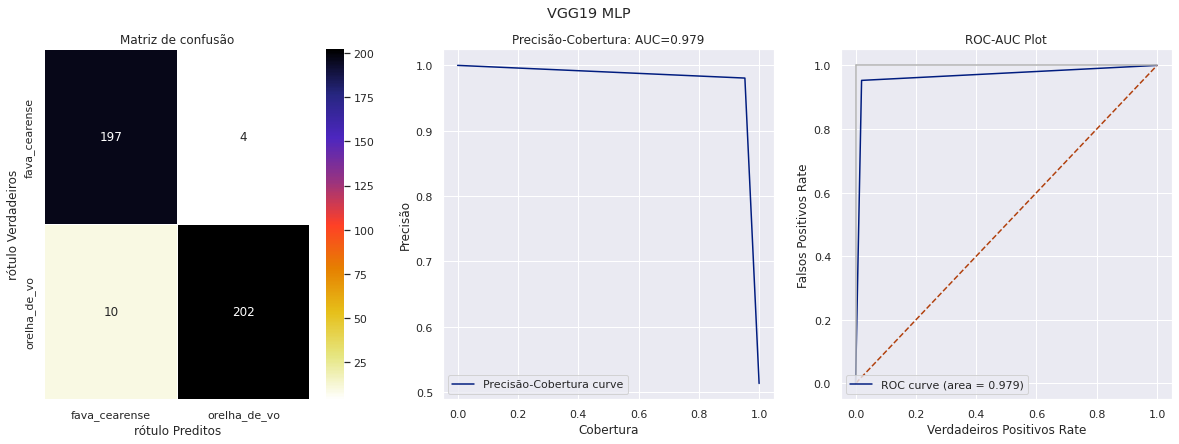

In [ ]:
resumo_modelo(model_vgg19, y_test.argmax(axis=1), pred_vgg19, "CMRmap_r", "VGG19 MLP")

# CNN COM SVM 

In [ ]:
svm_params = dict()

svm_params['C'] = stats.loguniform(1e-4, 1e2)
svm_params['kernel'] = ["poly","rbf","linear"]
svm_params['degree'] = stats.randint(2,5)
svm_params['gamma']= stats.loguniform(1e-4, 1e2)

## 1

In [ ]:
# load model
savedModel=load_model('/content/drive/My Drive/modelos/CNN/modelo/Model.h5')
# savedModel.summary()

from keras import backend as K
for l in range(len(savedModel.layers)):
  print(l, savedModel.layers[l])

## CNN

In [ ]:
%%time

X_train_rf, y_train_rf, X_test_rf, y_test_rf = extract_feature(load_model('/content/drive/My Drive/modelos/CNN MLP/modelo/Model.h5'), endlayers=5, initlayers=0)

best_model_svm = RandomizedSearchCV(SVC(probability=True), svm_params, n_iter=n_iter_search, cv=kfold, refit=True)
best_model_svm = best_model_svm.fit(X_train_rf, y_train_rf)
pred_svm  = best_model_svm.predict(X_test_rf)

CPU times: user 27.4 s, sys: 137 ms, total: 27.6 s
Wall time: 27.3 s


[INFO] CNN SVM evaluating network...
Best: 0.9813 
using {'C': 29.115026486768507, 'degree': 2, 'gamma': 0.0004780004165163952, 'kernel': 'poly'}
               precision    recall  f1-score   support

fava_cearense       0.99      0.98      0.98       201
 orelha_de_vo       0.98      0.99      0.99       212

     accuracy                           0.99       413
    macro avg       0.99      0.99      0.99       413
 weighted avg       0.99      0.99      0.99       413

----- ------------------------- -----
Acurácia de teste = 0.985
AUC = 0.988
Precisão = 0.981, cobertura = 0.991
F1 = 0.986
----- ------------------------- -----


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


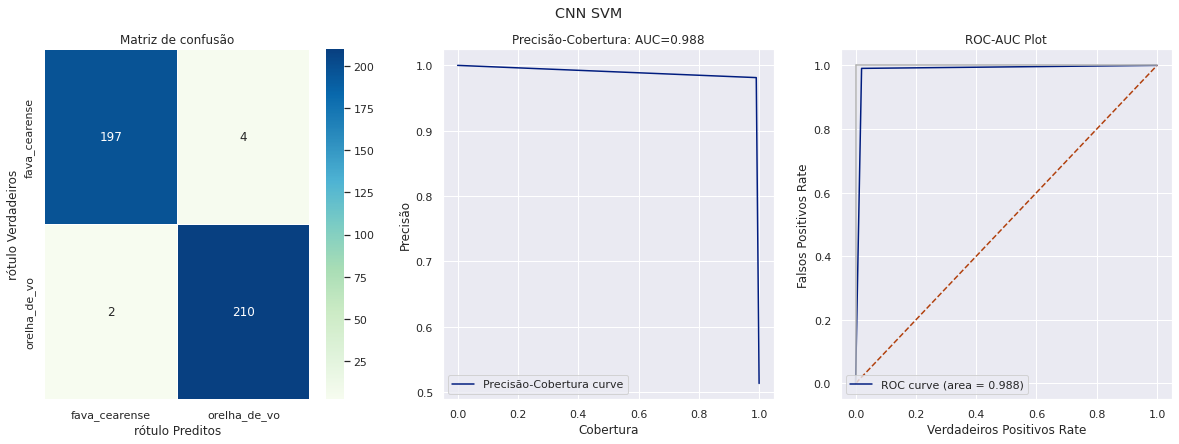

In [ ]:
resumo_modelo(best_model_svm, y_test_rf, pred_svm, "GnBu", "CNN SVM")

In [ ]:
filename="CNN SVM"
  
pd.DataFrame(best_model_svm.cv_results_).to_csv("/content/drive/My Drive/modelos/{0}/scores_{0}.csv".format(filename), sep=';')
# best_model_svm.best_estimator_.model.save_weights(filepath="/content/drive/My Drive/modelos/{}/weights/ModelWeights".format(filename))
# best_model_svm.best_estimator_.model.save('/content/drive/My Drive/modelos/{}/modelo/Model.h5'.format(filename), save_format='h5')

with open("/content/drive/My Drive/modelos/{0}/{0}.pkl".format(filename), 'wb') as outp:
  dump(best_model_svm, outp, HIGHEST_PROTOCOL)

## VGG 16

In [ ]:
%%time

X_train_rf, y_train_rf, X_test_rf, y_test_rf = extract_feature(load_model('/content/drive/My Drive/modelos/VGG16 MLP/modelo/Model.h5'), endlayers=20, initlayers=0)

best_model_svm = RandomizedSearchCV(SVC(probability=True), svm_params, n_iter=n_iter_search, cv=kfold, refit=True)
best_model_svm = best_model_svm.fit(X_train_rf, y_train_rf)
pred_svm  = best_model_svm.predict(X_test_rf)

CPU times: user 18.7 s, sys: 128 ms, total: 18.8 s
Wall time: 19.5 s


[INFO] VGG16 SVM evaluating network...
Best: 1.0000 
using {'C': 70.59256670518263, 'degree': 4, 'gamma': 0.0003084316500835303, 'kernel': 'linear'}
               precision    recall  f1-score   support

fava_cearense       0.96      0.96      0.96       194
 orelha_de_vo       0.96      0.97      0.97       219

     accuracy                           0.96       413
    macro avg       0.96      0.96      0.96       413
 weighted avg       0.96      0.96      0.96       413

----- ------------------------- -----
Acurácia de teste = 0.964
AUC = 0.974
Precisão = 0.964, cobertura = 0.968
F1 = 0.966
----- ------------------------- -----


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


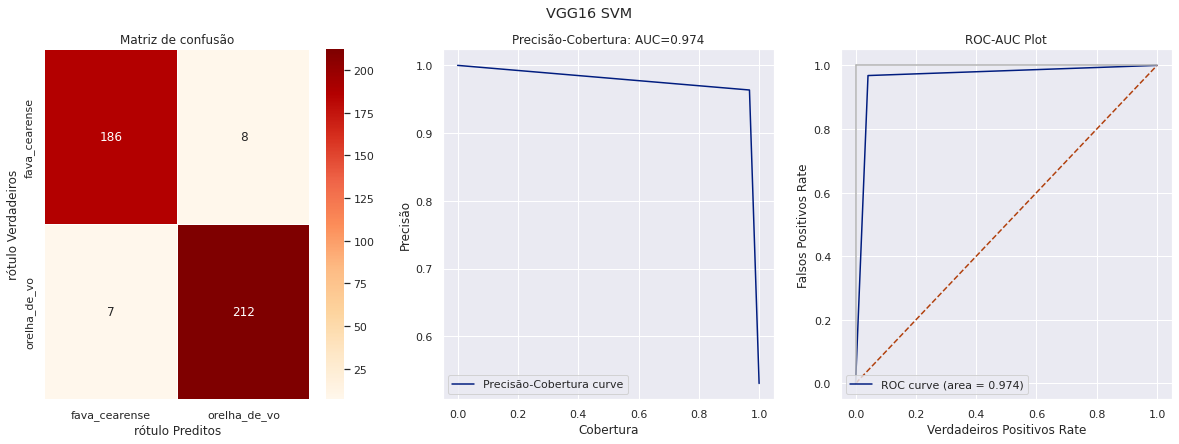

            Accuracia       ACC  Precision    Recall        F1  \
CNN TREE     0.973366  0.978926   0.964286  0.986301  0.975169   
VGG16 TREE   0.995157  0.997855   1.000000  0.990868  0.995413   
VGG19 TREE   0.992736  0.996783   1.000000  0.986301  0.993103   
VGG16 MLP    0.963680  0.974311   0.963636  0.968037  0.965831   
VGG16 SVM    0.963680  0.974311   0.963636  0.968037  0.965831   

                 Matrix Conf  
CNN TREE    (186, 8, 3, 216)  
VGG16 TREE  (194, 0, 2, 217)  
VGG19 TREE  (194, 0, 3, 216)  
VGG16 MLP   (186, 8, 7, 212)  
VGG16 SVM   (186, 8, 7, 212)  


In [ ]:
resumo_modelo(best_model_svm, y_test_rf, pred_svm, "OrRd", "VGG16 SVM")

## VGG 19

In [ ]:
%%time

X_train_rf, y_train_rf, X_test_rf, y_test_rf = extract_feature(load_model('/content/drive/My Drive/modelos/VGG19 MLP/modelo/Model.h5'), endlayers=23, initlayers=0)

best_model_svm = RandomizedSearchCV(SVC(probability=True), svm_params, n_iter=n_iter_search, cv=kfold, refit=True)
best_model_svm = best_model_svm.fit(X_train_rf, y_train_rf)
pred_svm  = best_model_svm.predict(X_test_rf)

CPU times: user 21.1 s, sys: 123 ms, total: 21.2 s
Wall time: 23.2 s


[INFO] VGG19 SVM evaluating network...
Best: 1.0000 
using {'C': 2.648996289929572, 'degree': 2, 'gamma': 11.27716062383664, 'kernel': 'poly'}
               precision    recall  f1-score   support

fava_cearense       0.96      0.96      0.96       201
 orelha_de_vo       0.96      0.97      0.96       212

     accuracy                           0.96       413
    macro avg       0.96      0.96      0.96       413
 weighted avg       0.96      0.96      0.96       413

----- ------------------------- -----
Acurácia de teste = 0.961
AUC = 0.971
Precisão = 0.958, cobertura = 0.967
F1 = 0.962
----- ------------------------- -----


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


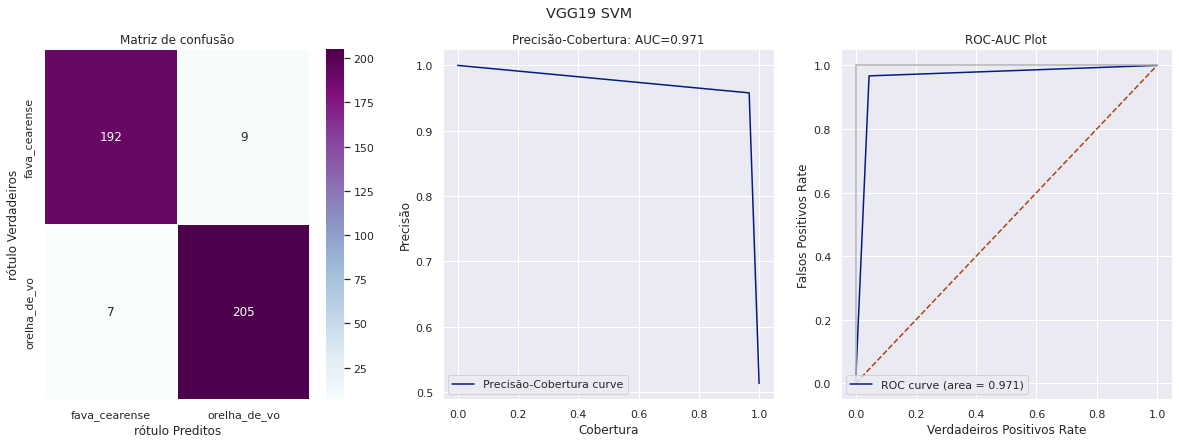

In [ ]:
resumo_modelo(best_model_svm, y_test_rf, pred_svm, "BuPu", "VGG19 SVM")

## Inception

In [ ]:
%%time

X_train_rf, y_train_rf, X_test_rf, y_test_rf = extract_feature(load_model('/content/drive/My Drive/modelos/Inception MLP/modelo/Model.h5'), endlayers=312, initlayers=0)

best_model_svm = RandomizedSearchCV(SVC(probability=True), svm_params, n_iter=n_iter_search, cv=kfold, refit=True)
best_model_svm = best_model_svm.fit(X_train_rf, y_train_rf)
pred_svm  = best_model_svm.predict(X_test_rf)

CPU times: user 46.6 s, sys: 273 ms, total: 46.8 s
Wall time: 47.7 s


[INFO] Inception SVM evaluating network...
Best: 1.0000 
using {'C': 0.08309712024880417, 'degree': 3, 'gamma': 6.75980235471052, 'kernel': 'linear'}
               precision    recall  f1-score   support

fava_cearense       0.97      0.99      0.98       201
 orelha_de_vo       0.99      0.97      0.98       212

     accuracy                           0.98       413
    macro avg       0.98      0.98      0.98       413
 weighted avg       0.98      0.98      0.98       413

----- ------------------------- -----
Acurácia de teste = 0.978
AUC = 0.986
Precisão = 0.986, cobertura = 0.972
F1 = 0.979
----- ------------------------- -----


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


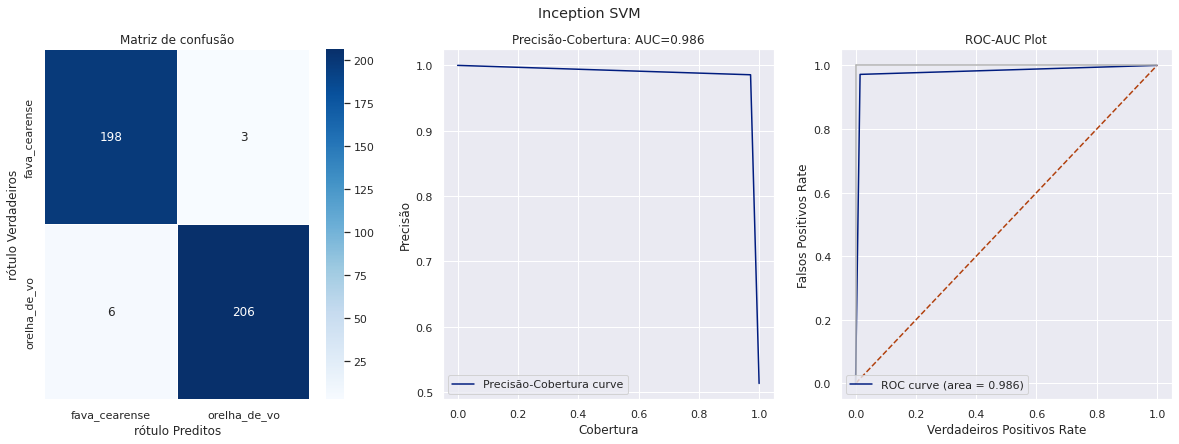

In [ ]:
resumo_modelo(best_model_svm, y_test_rf, pred_svm, "Blues", "Inception SVM")

# CNN com Tree

In [ ]:
tree_params = dict()

tree_params['tree__criterion'] = ["gini", "entropy"]
tree_params['tree__splitter'] = ["best", "random"]
tree_params['tree__min_samples_split'] = stats.uniform(loc=0, scale=1)
tree_params['tree__min_samples_leaf']= stats.uniform(loc=1e-6, scale=0.5)
tree_params['tree__max_leaf_nodes']= stats.randint(1, 1000)
tree_params['tree__max_depth']= stats.randint(1, 1000)

## CNN 

In [ ]:
%%time

X_train_rf, y_train_rf, X_test_rf, y_test_rf = extract_feature(load_model('/content/drive/My Drive/modelos/MLP/CNN MLP/modelo/Model.h5'), endlayers=5, initlayers=0)

pipe = Pipeline([('tree', DecisionTreeClassifier())])

best_model_tree = RandomizedSearchCV(pipe, tree_params, n_iter=n_iter_search, cv=kfold, refit=True)
best_model_tree = best_model_tree.fit(X_train_rf, y_train_rf)
pred_tree  = best_model_tree.predict(X_test_rf)

CPU times: user 5.44 s, sys: 2.27 s, total: 7.71 s
Wall time: 17.2 s


[INFO] CNN TREE evaluating network...
Best: 0.9813 
using {'tree__criterion': 'gini', 'tree__max_depth': 436, 'tree__max_leaf_nodes': 861, 'tree__min_samples_leaf': 0.0917183949330819, 'tree__min_samples_split': 0.7796910002727693, 'tree__splitter': 'best'}
               precision    recall  f1-score   support

fava_cearense       0.98      0.96      0.97       194
 orelha_de_vo       0.96      0.99      0.98       219

     accuracy                           0.97       413
    macro avg       0.97      0.97      0.97       413
 weighted avg       0.97      0.97      0.97       413

----- ------------------------- -----
Acurácia de teste = 0.973
AUC = 0.979
Precisão = 0.964, cobertura = 0.986
F1 = 0.975
----- ------------------------- -----


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


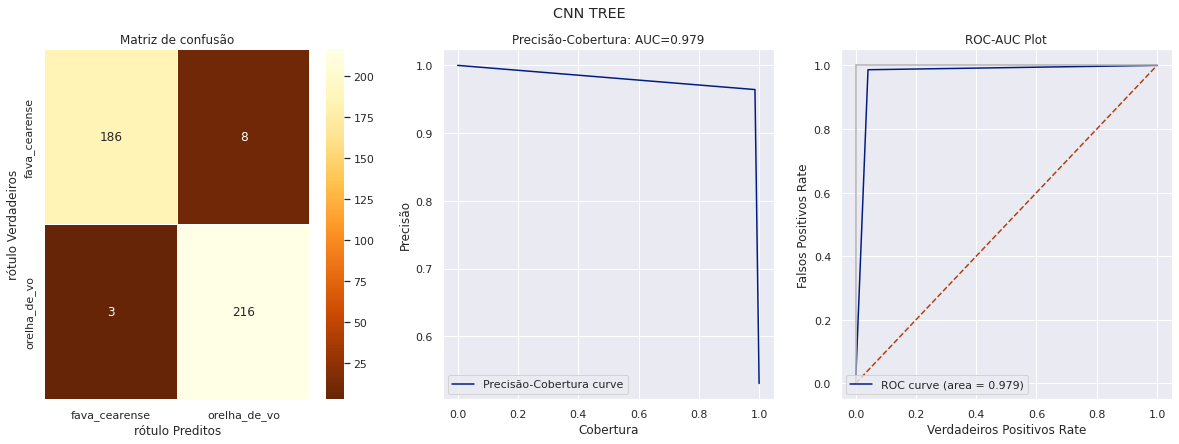

In [ ]:
resumo_modelo(best_model_tree, y_test_rf, pred_tree, "YlOrBr_r", "CNN TREE")

## VGG16

In [ ]:
%%time

X_train_rf, y_train_rf, X_test_rf, y_test_rf = extract_feature(load_model('/content/drive/My Drive/modelos/MLP/VGG16 MLP/modelo/Model.h5'), endlayers=20, initlayers=0)

pipe = Pipeline([('tree', DecisionTreeClassifier())])

best_model_vgg16_tree = RandomizedSearchCV(pipe, tree_params, n_iter=n_iter_search, cv=kfold, refit=True)
best_model_vgg16_tree = best_model_vgg16_tree.fit(X_train_rf, y_train_rf)
pred_vgg16_tree  = best_model_vgg16_tree.predict(X_test_rf)

CPU times: user 5.45 s, sys: 116 ms, total: 5.56 s
Wall time: 5.32 s


[INFO] VGG16 TREE evaluating network...
Best: 1.0000 
using {'tree__criterion': 'entropy', 'tree__max_depth': 670, 'tree__max_leaf_nodes': 633, 'tree__min_samples_leaf': 0.4109042219505434, 'tree__min_samples_split': 0.0012366797594094425, 'tree__splitter': 'random'}
               precision    recall  f1-score   support

fava_cearense       0.98      0.94      0.96       194
 orelha_de_vo       0.95      0.98      0.97       219

     accuracy                           0.96       413
    macro avg       0.96      0.96      0.96       413
 weighted avg       0.96      0.96      0.96       413

----- ------------------------- -----
Acurácia de teste = 0.964
AUC = 0.971
Precisão = 0.951, cobertura = 0.982
F1 = 0.966
----- ------------------------- -----


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


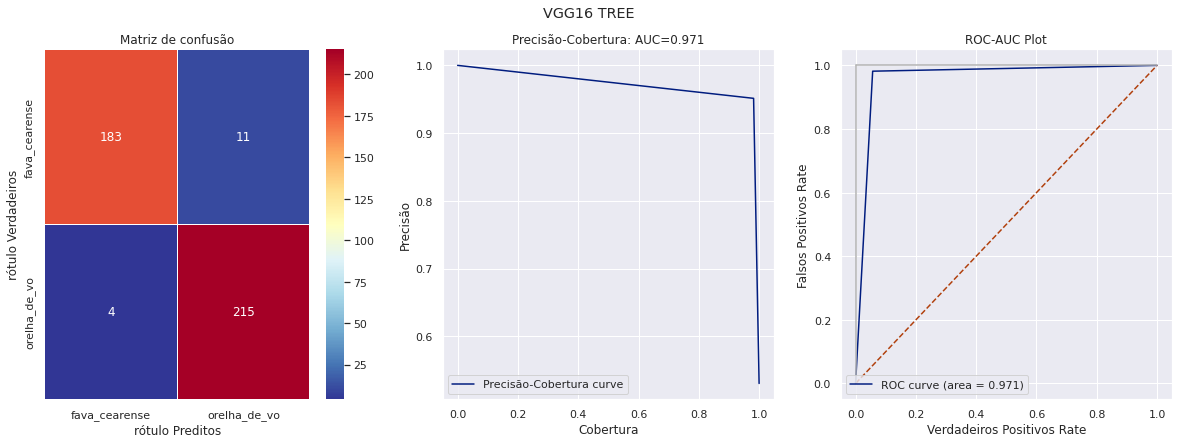

            Accuracia       ACC  Precision    Recall        F1  \
CNN TREE     0.973366  0.978926   0.964286  0.986301  0.975169   
VGG16 TREE   0.963680  0.971374   0.951327  0.981735  0.966292   
VGG19 TREE   0.992736  0.996783   1.000000  0.986301  0.993103   
VGG16 MLP    0.963680  0.974311   0.963636  0.968037  0.965831   
VGG16 SVM    0.963680  0.974311   0.963636  0.968037  0.965831   

                  Matrix Conf  
CNN TREE     (186, 8, 3, 216)  
VGG16 TREE  (183, 11, 4, 215)  
VGG19 TREE   (194, 0, 3, 216)  
VGG16 MLP    (186, 8, 7, 212)  
VGG16 SVM    (186, 8, 7, 212)  


In [ ]:
resumo_modelo(best_model_vgg16_tree, y_test_rf, pred_vgg16_tree, "RdYlBu_r", "VGG16 TREE")

## VGG19


In [ ]:
%%time

X_train_rf, y_train_rf, X_test_rf, y_test_rf = extract_feature(load_model('/content/drive/My Drive/modelos/MLP/VGG19 MLP/modelo/Model.h5'), endlayers=23, initlayers=0)

pipe = Pipeline([('tree', DecisionTreeClassifier())])

best_model_vgg19_tree = RandomizedSearchCV(pipe, tree_params, n_iter=n_iter_search, cv=kfold, refit=True)
best_model_vgg19_tree = best_model_vgg19_tree.fit(X_train_rf, y_train_rf)
pred_vgg19_tree  = best_model_vgg19_tree.predict(X_test_rf)

CPU times: user 6.73 s, sys: 400 ms, total: 7.12 s
Wall time: 7.73 s


[INFO] VGG19 TREE evaluating network...
Best: 0.9896 
using {'tree__criterion': 'gini', 'tree__max_depth': 296, 'tree__max_leaf_nodes': 320, 'tree__min_samples_leaf': 0.2872375565899559, 'tree__min_samples_split': 0.8418287767582721, 'tree__splitter': 'random'}
               precision    recall  f1-score   support

fava_cearense       0.98      1.00      0.99       194
 orelha_de_vo       1.00      0.99      0.99       219

     accuracy                           0.99       413
    macro avg       0.99      0.99      0.99       413
 weighted avg       0.99      0.99      0.99       413

----- ------------------------- -----
Acurácia de teste = 0.993
AUC = 0.997
Precisão = 1.000, cobertura = 0.986
F1 = 0.993
----- ------------------------- -----


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


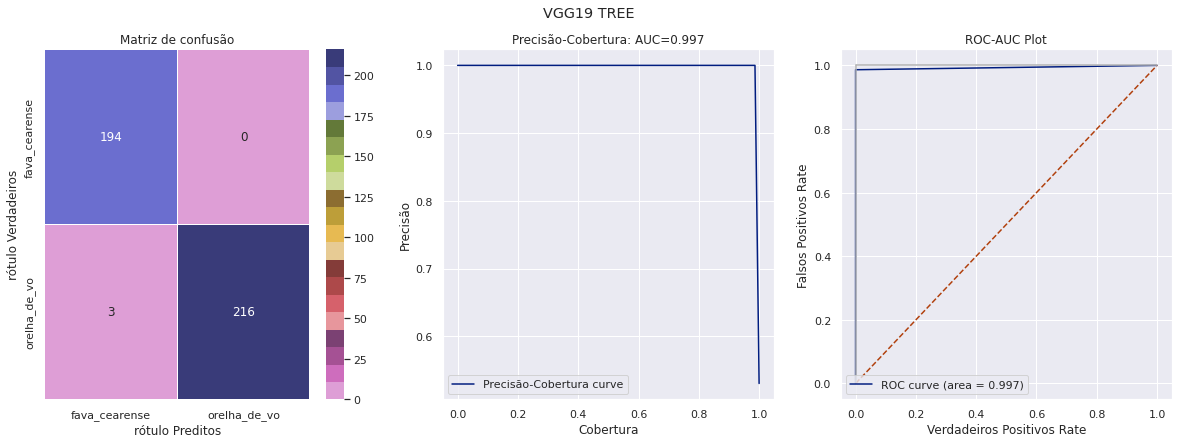

In [ ]:
resumo_modelo(best_model_vgg19_tree, y_test_rf, pred_vgg19_tree, "tab20b_r", "VGG19 TREE")

# Seleção de parametros manual

In [ ]:
%%time

arg_epochs=2
custon_batch_size=16

sgd_optimizer   = SGD(learning_rate=1e-4, momentum=9e-1)
adam_optimizer  = Adam(learning_rate=1e-4, decay=1e-4/arg_epochs)
nadam_optimizer = Nadam(learning_rate=1e-4)

model = modelo_cnn(width=largura, height=altura, depth=custon_depth, l2_penalty=l2(2e-4), dropout_rate=0.12, neurons=32, atvation='relu', activation='sigmoid', optimizer=adam_optimizer, n_class=2, mlp=True)

print("[INFO] training network for {} epochs...".format(arg_epochs))
H = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=custon_batch_size, epochs=arg_epochs, verbose=1)

[INFO] training network for 2 epochs...
Epoch 1/2
61/61 [==============================] - 4s 53ms/step - loss: 0.7232 - accuracy: 0.6098 - val_loss: 0.6020 - val_accuracy: 0.7845
Epoch 2/2
61/61 [==============================] - 3s 45ms/step - loss: 0.5642 - accuracy: 0.7700 - val_loss: 0.4995 - val_accuracy: 0.8475


[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       194
           1       0.95      0.96      0.96       219

    accuracy                           0.95       413
   macro avg       0.95      0.95      0.95       413
weighted avg       0.95      0.95      0.95       413

----- ------------------------- -----
Acurácia de teste = 0.954
AUC = 0.967
Precisão = 0.950, cobertura = 0.963
F1 = 0.957
----- ------------------------- -----


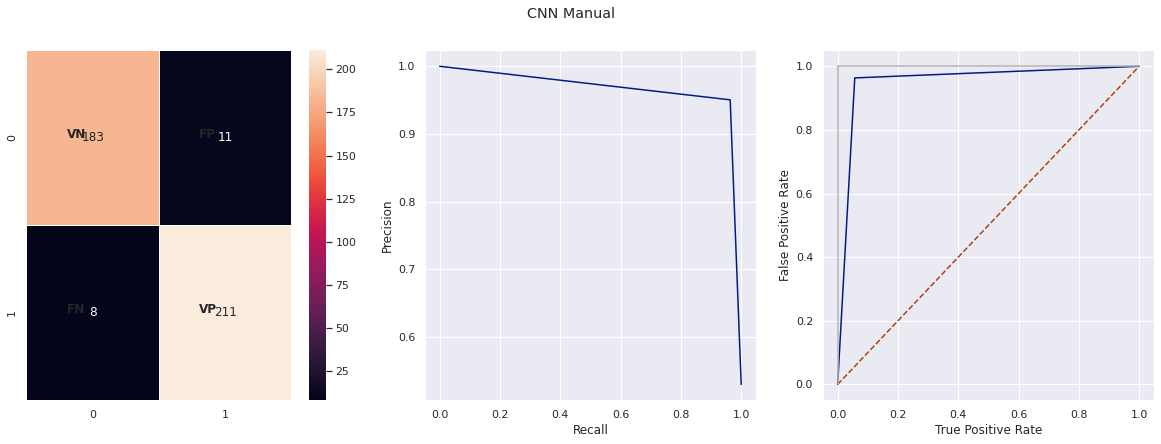

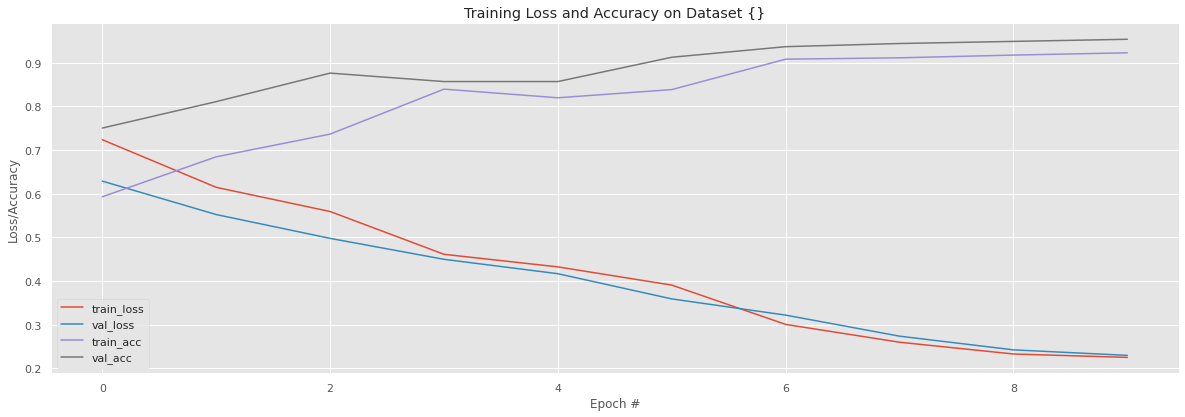

In [ ]:
print("[INFO] evaluating network...")
predictions = model.predict(X_test, batch_size=custon_batch_size)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))
plot_metrics(y_test, predict=predictions.argmax(axis=1), H=H, epochs=arg_epochs, description="CNN Manual")

In [ ]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 267, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 267, 200, 32)      8224      
                                                                 
 block1_pool (MaxPooling2D)  (None, 133, 100, 32)      0         
                                                                 
 block1_dropout (Dropout)    (None, 133, 100, 32)      0         
                                                                 
 out_flatten (Flatten)       (None, 425600)            0         
                                                                 
 dense_26 (Dense)            (None, 32)                13619232  
                                                                 
 dropout_17 (Dropout)        (None, 32)              

In [ ]:
last_layer = model.get_layer('out_flatten')
print('last layer output shape: ', last_layer.output_shape)
modelos = tf.keras.models.Model(inputs=last_layer.input, outputs=last_layer.output)
modelos.summary()

last layer output shape:  (None, 425600)
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 133, 100, 32)]    0         
                                                                 
 out_flatten (Flatten)       (None, 425600)            0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_test.argmax(axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,

# Comparação

In [ ]:
Metricas2 = pd.DataFrame.from_dict(
    Metrics,
    orient="index",
    columns=["Accuracia", "ACC", "Precision","Recall", "F1", "Matrix Conf"],
)
# Metricas.loc['VGG']=[0.966102,	0.981094,	0.985782,	0.949772,	0.967442,	(191, 3, 11, 208)]
Metricas2.to_csv("/content/drive/My Drive/modelos/Metricas_.csv", sep=';')
Metricas2

Accuracia       ACC  Precision    Recall        F1  \
CNN TREE     0.973366  0.978926   0.964286  0.986301  0.975169   
VGG16 TREE   0.963680  0.971374   0.951327  0.981735  0.966292   
VGG19 TREE   0.992736  0.996783   1.000000  0.986301  0.993103   
VGG16 MLP    0.963680  0.974311   0.963636  0.968037  0.965831   
VGG16 SVM    0.963680  0.974311   0.963636  0.968037  0.965831   

                  Matrix Conf  
CNN TREE     (186, 8, 3, 216)  
VGG16 TREE  (183, 11, 4, 215)  
VGG19 TREE   (194, 0, 3, 216)  
VGG16 MLP    (186, 8, 7, 212)  
VGG16 SVM    (186, 8, 7, 212)

In [ ]:
Metricas = pd.DataFrame.from_dict(
    Metrics,
    orient="index",
    columns=["Accuracia", "ACC", "Precision","Recall", "F1", "Matrix Conf"],
)
# Metricas.loc['VGG']=[0.966102,	0.981094,	0.985782,	0.949772,	0.967442,	(191, 3, 11, 208)]
Metricas.to_csv("/content/drive/My Drive/modelos/Metricas_12345678.csv", sep=';')
Metricas

Accuracia       ACC  Precision    Recall        F1  \
DECISION TREE   0.966102  0.977596    0.97235  0.963470  0.967890   
VGG16 TREE      0.990315  0.995710    1.00000  0.981735  0.990783   
CNN TREE        0.990315  0.995710    1.00000  0.981735  0.990783   
VGG19 TREE      0.990315  0.995710    1.00000  0.981735  0.990783   

                    Matrix Conf  
DECISION TREE  (188, 6, 8, 211)  
VGG16 TREE     (194, 0, 4, 215)  
CNN TREE       (194, 0, 4, 215)  
VGG19 TREE     (194, 0, 4, 215)

In [ ]:
df= pd.DataFrame.from_dict(
    [],
    orient="index",
    columns=["Accuracia", "ACC", "Precision","Recall", "F1", "Matrix Conf"],
)

df.loc["CNN MLP"]=[0.9539951573849879,0.9657071268256547,0.9464285714285714,0.9680365296803652,0.9571106094808125,(182, 12, 7, 212)]
df.loc["VGG16 MLP"]= [0.9636803874092009,  0.9743110229295509,  0.9636363636363636,  0.9680365296803652,  0.9658314350797266,  (186, 8, 7, 212)]
#df.loc["VGG19 MLP"]=[0.9661016949152542,0.9788128940058114,0.9805825242718447,0.9528301886792453,0.9665071770334929,(197, 4, 10, 202)]
#df.loc["Inception MLP"]=[0.9782082324455206,0.9859359456291105,0.9856459330143541,0.9716981132075472,0.9786223277909739,(198, 3, 6, 206)]

df.loc["CNN SVM"]=[0.9854721549636803,0.9883585319814544,0.9813084112149533,0.9905660377358491,0.9859154929577464,(197, 4, 2, 210)]
df.loc['VGG16 SVM']= [0.9636803874092009,0.9743110229295509,0.9636363636363636,0.9680365296803652,0.9658314350797266,(186, 8, 7, 212)]
#df.loc["VGG19 SVM"]=[0.9612590799031477,0.9709371049257448,0.9579439252336449,0.9669811320754716,0.9624413145539905,(192, 9, 7, 205)]
#df.loc["Inception SVM"]=[0.9782082324455206,0.9859359456291105,0.9856459330143541,0.9716981132075472,0.9786223277909739,(198, 3, 6, 206)]

df.loc["CNN TREE"]=[0.9733656174334141,0.978925503333444,0.9642857142857143,0.9863013698630136,0.9751693002257336,(186, 8, 3, 216)]
df.loc['VGG16 TREE']=[0.9636803874092009,0.9713739117349417,0.9513274336283186,0.9817351598173516,0.9662921348314607,(183, 11, 4, 215)]
#df.loc["VGG19 TREE"]=[0.9927360774818402,0.9967826461905868,1.0,0.9863013698630136,0.993103448275862,(194, 0, 3, 216)]
df.to_csv("/content/drive/My Drive/modelos/Metricas.csv", sep=';')
df

Accuracia       ACC  Precision    Recall        F1  \
CNN MLP      0.953995  0.965707   0.946429  0.968037  0.957111   
VGG16 MLP    0.963680  0.974311   0.963636  0.968037  0.965831   
CNN SVM      0.985472  0.988359   0.981308  0.990566  0.985915   
VGG16 SVM    0.963680  0.974311   0.963636  0.968037  0.965831   
CNN TREE     0.973366  0.978926   0.964286  0.986301  0.975169   
VGG16 TREE   0.963680  0.971374   0.951327  0.981735  0.966292   

                  Matrix Conf  
CNN MLP     (182, 12, 7, 212)  
VGG16 MLP    (186, 8, 7, 212)  
CNN SVM      (197, 4, 2, 210)  
VGG16 SVM    (186, 8, 7, 212)  
CNN TREE     (186, 8, 3, 216)  
VGG16 TREE  (183, 11, 4, 215)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


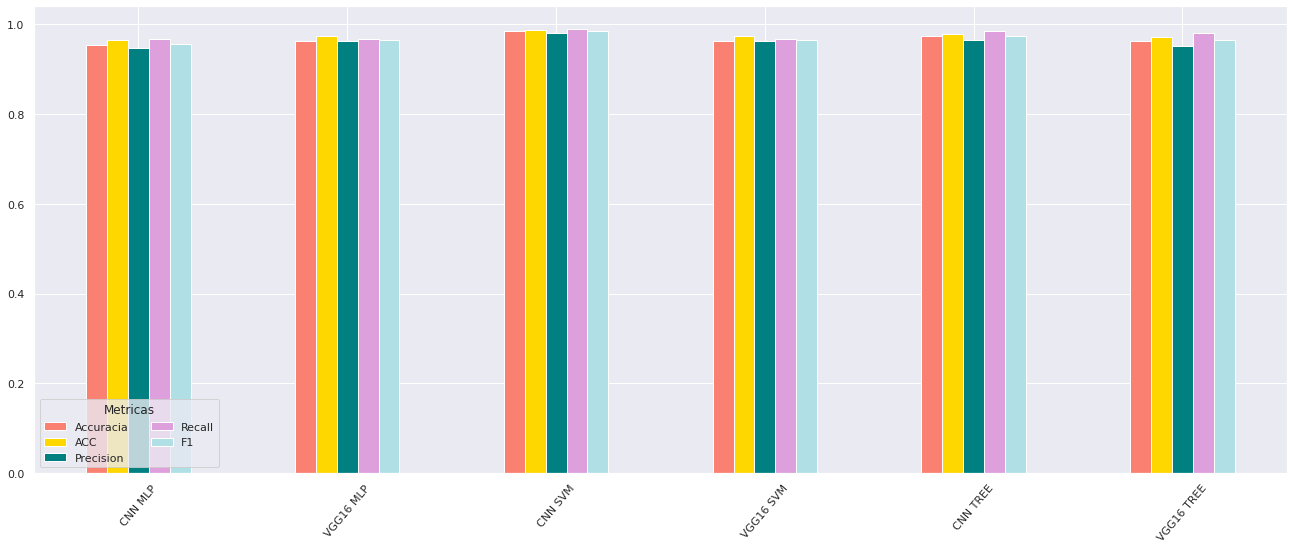

In [ ]:
fig = df.plot(kind='bar', figsize=(20, 8),color = ['salmon','gold','teal','plum','powderblue'], rot=50).legend(
    loc='lower left', ncol=2, title="Metricas"
)

fig.get_figure().savefig('/content/drive/My Drive/modelos/metricas_.eps', dpi=500)
fig.get_figure().savefig('/content/drive/My Drive/modelos/metricas_.png', dpi=500)

# RASCUNHOS

In [ ]:
Metrics

{'CNN TREE': [0.9733656174334141,
  0.978925503333444,
  0.9642857142857143,
  0.9863013698630136,
  0.9751693002257336,
  (186, 8, 3, 216)],
 'VGG16 MLP': [0.9636803874092009,
  0.9743110229295509,
  0.9636363636363636,
  0.9680365296803652,
  0.9658314350797266,
  (186, 8, 7, 212)],
 'VGG16 SVM': [0.9636803874092009,
  0.9743110229295509,
  0.9636363636363636,
  0.9680365296803652,
  0.9658314350797266,
  (186, 8, 7, 212)],
 'VGG16 TREE': [0.9636803874092009,
  0.9713739117349417,
  0.9513274336283186,
  0.9817351598173516,
  0.9662921348314607,
  (183, 11, 4, 215)],
 'VGG19 TREE': [0.9927360774818402,
  0.9967826461905868,
  1.0,
  0.9863013698630136,
  0.993103448275862,
  (194, 0, 3, 216)]}

In [ ]:
nome="best_model_cnn"
description = "CNN MLP"

# load it again
with open("/content/drive/My Drive/modelos/{}.pkl".format(nome), "rb") as file:
  model = load(file)

pred = model.predict(X_test)

print("[INFO] {} evaluating network...".format(description))
print("Best: {:.4f} \nusing {}".format(model.best_score_, model.best_params_))
print(classification_report(y_test.argmax(axis=1), pred, target_names=list(encode.classes_)))
plot_metrics(y_test.argmax(axis=1), pred, description, 'Accent_r')
save_object(model, description)